# Projections and best approximations

This activity is concerned with how a finite element space approximates functions outside it. *Given a function $\newcommand{\om}{\varOmega}$ $u \in L^2(\om)$, how best can we approximate it using functions in a finite element subspace $W_{hp}$?*  A quantitative answer to this question can be provided by measuring the **best approximation error** (BAE) 

$$
\text{BAE}(u) = \inf_{v \in W_{hp}} \| u -v \|_{L^2(\om)}.
$$

We are interested in  seeing how this BAE becomes small as the mesh size $h$ is decreased  and as the polynomial degree $p$ increases. Here 

$$
  W_{hp} =  \{ w: w|_K \text{ is a polynomial of degree $\le p$ on each mesh element }K\}.
$$

This space is often called the *discontinuous Galerkin (DG) space* and is your second example of a finite element space. It differs from your first example, the Lagrange finite element space, in that functions in $W_{hp}$ can be discontinous. Clearly, $W_{hp}$ is a subspace of $L^2(\om)$.

## Orthogonal projections

To compute BAE, we use orthogonal projections. Recall two properties of orthogonal projections we proved in the lectures.  Let $X$ be an inner product space over $\mathbb R$ and let $P: X \to X$ be an orthogonal projection onto a subspace $\newcommand{\ran}{\text{range}}$  $M = \ran(P)$ of $X$.

*Property 1.*    $Px$ is the **best approximation** to an $x \in X$ from the subspace $M$,   namely, 

$$
\| x - Px \|_X = \inf_{m \in M} \| x - m \|_X.
$$

The right hand side is the BAE$(x)$ of $x$ from $M$. Thus Property 1
implies that we can compute BAE$(x)$ if we can compute $Px$ and the norm of the difference  $\| x - Px \|_X$.

*Property 2.*  $Px$ satisfies 

$$
(Px , m)_X = (x, m)_X
$$

for all $x \in X$ and $m \in M$. This equation helps us compute $P x$, as we shall now illustrate.

## Computing the $L^2$-orthogonal projection 

Let $Q_{hp}$ denote the $\newcommand{\om}{\varOmega}$ $L^2(\om)$-orthogonal projection onto $W_{hp}$.
Given a $u \in L^2(\om)$ we want to compute the function $q = Q_{hp} u$ in $W_{hp}$. By Property 2, 

$$
(q, m)_{L^2(\om)} = (u, m)_{L^2(\om)} 
$$

for all $m \in W_{hp}$.

We will encounter many more equations of this type in this course. They are all of the form

$$
a(q, m) = b(m).
$$

For the projection, $a(\cdot,\cdot)$ is the just the inner product $(\cdot, \cdot)_{L^2(\om)}$, while $b(\cdot)$ equals $(u, \cdot)_{L^2(\om)}$.
It is useful to get acquainted with some terminology related to equations like $a(q, m) = b(m)$  rightaway:
- The set of functions from which the solution $q$  is to be found is called the set of **trial functions**.
- The set of functions $m$ for which the equation must hold is called the set of  **test functions**. (In the projection example, the spaces of trial and test functions are the same, but they need not be so in other examples.)
- The right hand side is called a **linear form** since it is linear in the test function $m$. (In the projection example, it contains the problem data involving the known function $u$.)
- The left handside is called a **bilinear form** (since it is linear in both the trial function $q$ and the test function $m$).

*You will see these names being used for certain ngsolve objects below.*

In [1]:
import ngsolve as ng
from netgen.occ import unit_square
from ngsolve import dx, x, y, sin, BilinearForm, LinearForm, Mesh

def ProjectL2(u, W):
    """ Input: u as a CF.
        Output: L^2-projection Q u as a GF. """
    Qu = ng.GridFunction(W)
    q = W.TrialFunction()
    m = W.TestFunction()
    a = BilinearForm(q*m*dx)
    b = LinearForm(u*m*dx)
    
    with ng.TaskManager():
        a.Assemble()
        b.Assemble()
        Qu.vec.data = a.mat.Inverse(inverse='sparsecholesky') * b.vec
    return Qu    

Before explaining the code, let us visualize a smooth function and its projection into the space of piecewise constant functions.

In [2]:
from ngsolve.webgui import Draw

h = 0.2
mesh = ng.Mesh(unit_square.GenerateMesh(maxh=h))
p = 0    # piecewise constant DG space
Whp = ng.L2(mesh, order=p)

u = sin(5 * x * y)
Qu = ProjectL2(u, Whp)

Draw(u, mesh); Draw(Qu);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

## Conversion to a matrix problem

In the code above, notice the `Assemble` and `Inverse` methods. The first converts equations of the form 

$$
a(q, m) = b(m)
$$

for $q, m$ in some space $W$ into a matrix system, once a basis is set, as explained next. 

Suppose $\phi_1, \ldots, \phi_N$ form a set of basis functions of $W$. Then expanding the unknown function $q \in W$ in that basis, 

$$
q = \sum_{j=1}^N X_j \phi_j,
$$

we find that, with $m=\phi_i$, the equations 

$$
\sum_{j=1}^N a(\phi_j, \phi_i)\, X_j = b(\phi_i)
$$

hold for every $i=1, \ldots, N$. Hence, defining a matrix $A \in \mathbb{R}^{N \times N}$ and a vector $B \in \mathbb{R}^N$ by 

$$
A_{ij} = a(\phi_j, \phi_i), \qquad B_i = b(\phi_i),
$$

we have converted the problem of finding $q \in W$ into a problem of finding a vector $X \in \mathbb{R}^N$ satisfying 

$$
A X = B.
$$

This is the process that happens behind the scenes when the `Assemble` method is called. In the code for the functoin `ProjectL2`,  the object `a.mat` contains the matrix $A$ (in a sparse format) and `b.vec` contains the vector $B$ after the `Assemble` methods are completed.

To compute $X$, we need to invert the matrix $A$, namely $X = A^{-1} B$. This is what happens when the method  `a.mat.Inverse` is called. 

## Successive mesh refinements

We now proceed to study the best approximation error over a collection of meshes whose *element shapes* do not vary too much over the collection, even if their *element sizes* might vary considerably. A sequence of increasingly finer meshes where the element angles never change from those of the coarsest mesh is obtained by a simple *uniform refinement*. This is illustrated in the sequence of mesh images below.

In [3]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.3))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [4]:
mesh.ngmesh.Refine(); Draw(mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [5]:
mesh.ngmesh.Refine(); Draw(mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

Clearly this process of uniform refinement, when started on any coarse mesh, does not generate any new angles within the new elements, i.e., each triangular element of this infinite sequence of meshes is similar (in the geometric sense) to one of the triangles in the initial coarse mesh. 

## Projections on uniform refinements

Next, we compute the $L^2$ projection on a sequence of uniform refinements, starting from a very coarse mesh, using the function below.

In [6]:
from ngsolve import Integrate, sqrt
import numpy as np

def ProjectOnSuccessiveRefinements(u, p=0, hcoarse=1, nrefinements=8):                                   
    """Project to f.e. spaces on a sequence of uniformly refined meshes."""
    
    Qus = []; errors = []; meshes = []; ndofs = []
    mesh = ng.Mesh(unit_square.GenerateMesh(maxh=hcoarse))
    
    for ref in range(nrefinements): 
        W = ng.L2(mesh, order=p)
        Qu = ProjectL2(u, W)         
        sqrerr = (Qu - u)**2
      
        Qus.append(Qu) 
        errors.append(sqrt(Integrate(sqrerr, mesh)))
        meshes.append(ng.Mesh(mesh.ngmesh.Copy()))
        ndofs.append(W.ndof) 
      
        mesh.ngmesh.Refine()

    return Qus, np.array(errors), ndofs, meshes

We will select an infinitely smooth function $u$ for the initial experiments (and you will experiment with less regular functions in exercises). We select a smooth $u$ with some oscillations  (as otherwise the approximation errors rapidly become too close to machine precision).

In [7]:
u = sin(5*x*y)
Qus, es, ns, _ = ProjectOnSuccessiveRefinements(u, p=0)
errors = {0: es}; ndofs = {0: ns}
es  # display the sequence of error norms just computed

array([0.61147848, 0.3888668 , 0.19805796, 0.09974437, 0.04996571,
       0.02499467, 0.01249882, 0.00624959])

Observe that this sequence of error norms are decreasing, approximately halving at each step. This immediately gives us an indication of the expected rate of convergence of the error.  But anticipating more general error sequences in other case, let us get organized on rate computation.

## Estimate rate of convergence 

We want to estimate at what rate the errors on successive refinements (stored in the above list `es`) go to zero.  Let $e_i$ denote the $i$th element of the list.


Specifically, what we would like to determine is the number $r$, the **rate of convergence**, such that the errors are bounded by $O(h^r).$
If the sequence $e_i$ goes to zero like $O(h_i^r)$, then  since the refinement pattern dictates
$$
h_i = \frac{h_0}{2^i}, 
$$ 
we should see $e_{i+1} / e_i  \sim O(2^{-r})$. Hence to estimate $r$, we compute 
$$
\log_2 \frac{e_{i+1}}{ e_i}.
$$
These logarithms are computed and tabulated together with the error numbers using the formatting function below.

In [8]:
# Load a small module; attempt install if not found
try:
    from prettytable import PrettyTable
except ModuleNotFoundError:
    try:
        # this works only on pyodide
        import micropip
        await micropip.install("prettytable")
        from prettytable import PrettyTable
    except ModuleNotFoundError:
        # works locally, on jupyterhub, etc
        !pip3 install prettytable
        from prettytable import PrettyTable

In [9]:
def TabulateRate(name, dat, h0=1):
    """Inputs: 
        name = Name for second (error norm) column, 
        dat = list of error data on successive refinements
        log2h0inv = log2(1/h0), where h0 is coarsest meshsize.
    """
    col = ['h', name, 'rate']
    t = PrettyTable()
    h0col = ['%g'%h0]
    t.add_column(col[0], h0col + [h0col[0] + '/' + str(2**i) 
                                  for i in range(1, len(dat))])
    t.add_column(col[1], ['%.12f'%e for e in dat])
    t.add_column(col[2], ['*'] + \
                 ['%1.2f' % r 
                  for r in np.log(dat[:-1]/dat[1:])/np.log(2)])
    print(t)

Next, we will apply this function to tabulate rates of convergence for each $p$ using a series of uniformly refined meshes. Both the error norms and the rate computed using the log-technique are tabulated for each degree considered. 

#### $p=0$ case

In [10]:
TabulateRate('L2norm(Pu-u)', es)  # compute rate & tabulate previous p=0 results

+-------+----------------+------+
|   h   |  L2norm(Pu-u)  | rate |
+-------+----------------+------+
|   1   | 0.611478476406 |  *   |
|  1/2  | 0.388866803112 | 0.65 |
|  1/4  | 0.198057959521 | 0.97 |
|  1/8  | 0.099744374674 | 0.99 |
|  1/16 | 0.049965710998 | 1.00 |
|  1/32 | 0.024994670078 | 1.00 |
|  1/64 | 0.012498815701 | 1.00 |
| 1/128 | 0.006249593053 | 1.00 |
+-------+----------------+------+


#### $p=1$ case

In [11]:
def DisplayL2BAE(u, p=1):
    _, es, ns, _ = ProjectOnSuccessiveRefinements(u, p=p)
    errors[p] = es; ndofs[p] = ns  # store for later use
    TabulateRate('L2norm(Pu-u)', es)

DisplayL2BAE(u, p=1)

+-------+----------------+------+
|   h   |  L2norm(Pu-u)  | rate |
+-------+----------------+------+
|   1   | 0.628617219170 |  *   |
|  1/2  | 0.157887741212 | 1.99 |
|  1/4  | 0.053671603964 | 1.56 |
|  1/8  | 0.014088143973 | 1.93 |
|  1/16 | 0.003561180656 | 1.98 |
|  1/32 | 0.000892711108 | 2.00 |
|  1/64 | 0.000223328337 | 2.00 |
| 1/128 | 0.000055841488 | 2.00 |
+-------+----------------+------+


#### $p=2$ case

In [12]:
DisplayL2BAE(u, p=2)

+-------+----------------+------+
|   h   |  L2norm(Pu-u)  | rate |
+-------+----------------+------+
|   1   | 0.184351530565 |  *   |
|  1/2  | 0.044795004555 | 2.04 |
|  1/4  | 0.005950170265 | 2.91 |
|  1/8  | 0.000751616385 | 2.98 |
|  1/16 | 0.000094338399 | 2.99 |
|  1/32 | 0.000011805404 | 3.00 |
|  1/64 | 0.000001476093 | 3.00 |
| 1/128 | 0.000000184525 | 3.00 |
+-------+----------------+------+


#### $p=3$ case 

In [13]:
DisplayL2BAE(u, p=3)

+-------+----------------+------+
|   h   |  L2norm(Pu-u)  | rate |
+-------+----------------+------+
|   1   | 0.035275243280 |  *   |
|  1/2  | 0.000765944153 | 5.53 |
|  1/4  | 0.000104425075 | 2.87 |
|  1/8  | 0.000006066675 | 4.11 |
|  1/16 | 0.000000370675 | 4.03 |
|  1/32 | 0.000000023029 | 4.01 |
|  1/64 | 0.000000001437 | 4.00 |
| 1/128 | 0.000000000090 | 4.00 |
+-------+----------------+------+


#### $p=4$ case

In [14]:
DisplayL2BAE(u, p=4)

+-------+----------------+------+
|   h   |  L2norm(Pu-u)  | rate |
+-------+----------------+------+
|   1   | 0.040081194342 |  *   |
|  1/2  | 0.000991785394 | 5.34 |
|  1/4  | 0.000081246111 | 3.61 |
|  1/8  | 0.000002671363 | 4.93 |
|  1/16 | 0.000000084400 | 4.98 |
|  1/32 | 0.000000002645 | 5.00 |
|  1/64 | 0.000000000083 | 5.00 |
| 1/128 | 0.000000000003 | 5.00 |
+-------+----------------+------+


These observations clearly suggest that the rate of convergence appears to be $p+1$ when polynomial degree $p$ is used. 

Indeed, we will prove in a later lecture that
$$
\inf_{ w \in W_{hp}} \| u - w \|_{L^2(\om)} \le O(h^{p+1}).
$$
Rigorous approximation estimates like these form a basic pillar of finite element theory.

## Accuracy vs. degrees of freedom

During the above computations, we have also stored $\dim(W_{hp})$, or the **number of degrees of freedom**. This is useful when trying to gauge how much bang for the buck we obtain when using various meshes and various orders $p$.

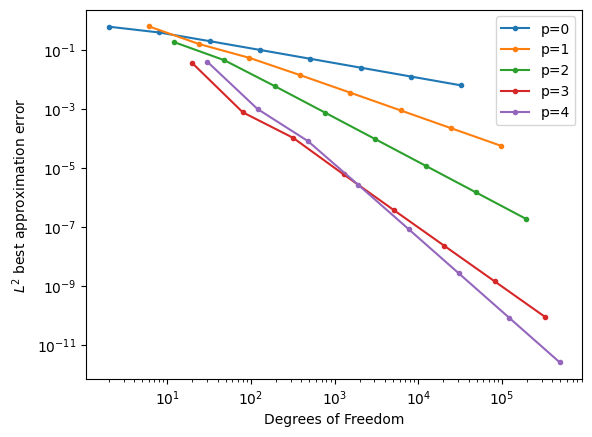

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 

for p in range(5):
    plt.loglog(ndofs[p], errors[p], '.-', label='p=%d'%p)

plt.xlabel('Degrees of Freedom')
plt.ylabel('$L^2$ best approximation error'); plt.legend();

We see from these results that for the smooth `u` under consideration,  the accuracy of its best approximation, measured *per* degree of freedom increases (quite dramatically) when using higher $p$.

<hr>

<div class="alert alert-info">
    <b><font color=red>Exercise:</font></b>  Give a formula for the dimension of $W_{hp}$ in terms of a mesh quantity and $p$.
</div>


*Note:*  We stored this dimension, for the meshes and the $p$-values we used in the above computations, in the   `ndofs` variable:

In [16]:
ndofs

{0: [2, 8, 32, 128, 512, 2048, 8192, 32768],
 1: [6, 24, 96, 384, 1536, 6144, 24576, 98304],
 2: [12, 48, 192, 768, 3072, 12288, 49152, 196608],
 3: [20, 80, 320, 1280, 5120, 20480, 81920, 327680],
 4: [30, 120, 480, 1920, 7680, 30720, 122880, 491520]}

<div class="alert alert-info">
    <b><font color=red>Exercise:</font></b>  Modify the above computations for the Lagrange finite element space  $V_{hp} = \{ v: v $ is continuous and $
v|_K $ is a polynomial of degree $\le p$ on each mesh element $K\}$ for $p=1, 2, \ldots, 4$.  At what rate does the best approximation error 
$$
\inf_{ w \in V_{hp}} \| u - w \|_{L^2(\om)} 
$$
appear to converge to zero? 
</div>



<div class="alert alert-info">
    <b><font color=red>Exercise:</font></b>
Modify the above computations to determine the rate of convergence of the best approximation error of the Lagrange finite element space $V_{hp}$ in the following  stronger norm
$$
\| u \|_{H^1(\om)} := \left( \| u \|_{L^2(\om)}^2 + \| \partial_x u\|_{L^2(\om)}^2 + \| \partial_y u\|_{L^2(\om)}^2 \right)^{1/2}.
$$
At what rate does the best approximation error 
$$
\inf_{ w \in V_{hp}} \| u - w \|_{H^1(\om)} 
$$
appear to converge to zero? 
</div>